In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
import os

# ==============================================================================
#                        MEMUAT DATASET AWAL
# ==============================================================================
try:
    df_raw = pd.read_csv("apachejit_total.csv")
    print("Dataset awal 'apachejit_train.csv' berhasil dimuat.")
except FileNotFoundError:
    print("Error: File 'apachejit_train.csv' tidak ditemukan.")
    print("Pastikan file dataset berada di folder yang sama dengan skrip ini.")
    exit()

# ==============================================================================
#                 ANALISIS DATA SEBELUM PREPROCESSING
# ==============================================================================
print("\n" + "="*60)
print("                 ANALISIS DATA SEBELUM PREPROCESSING")
print("="*60)

# --- Lampiran 1: Statistik Deskriptif (SEBELUM) ---
print("\n--- Lampiran 1: Statistik Deskriptif (SEBELUM) ---")
stats_before = df_raw.describe(include='all').T
nan_before = df_raw.isnull().sum()
stats_before['jumlah_nan'] = nan_before
print(stats_before.to_string())


# --- Lampiran 2: Visualisasi Distribusi Data (SEBELUM) ---
print("\n--- Lampiran 2: Visualisasi (SEBELUM) ---")
print("--> Menampilkan plot. Tutup jendela plot untuk melanjutkan...")

# Histogram
df_raw[['la', 'ld', 'nf']].hist(bins=30, figsize=(10, 6))
plt.suptitle("Lampiran 2 - Histogram Fitur Numerik (Sebelum)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Boxplot
df_raw[['la', 'ld', 'nf']].plot(kind='box', subplots=True, layout=(1,3), figsize=(12,5), sharey=False)
plt.suptitle("Lampiran 2 - Boxplot Fitur Numerik (Sebelum)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Heatmap Korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(df_raw[['la', 'ld', 'nf', 'buggy']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Lampiran 2 - Heatmap Korelasi (Sebelum)")
plt.show()


# --- Mengambil Data Awal untuk Perbandingan ---
initial_rows, initial_cols = df_raw.shape
initial_nans = df_raw.isnull().sum().sum()

# ==============================================================================
#                 PROSES PREPROCESSING (SESUAI LAPORAN ANDA)
# ==============================================================================
print("\n" + "="*60)
print("                 MEMULAI PROSES PREPROCESSING DATA")
print("="*60)

# 1. Pembersihan Data
df_processed = df_raw.dropna(subset=['la', 'ld', 'nf', 'buggy']).copy()
df_processed['author_date'] = pd.to_datetime(df_processed['author_date'], errors='coerce')
df_processed.dropna(subset=['author_date'], inplace=True)
print("1. Pembersihan Data: Nilai NaN dihapus.")

# 2. Pembuatan Fitur Baru
df_processed['code_churn'] = df_processed['la'] + df_processed['ld']
print("2. Pembuatan Fitur Baru: 'code_churn' telah ditambahkan.")

# 3. Reduksi & Seleksi Data
features = ['la', 'ld', 'nf', 'code_churn']
target = 'buggy'
X = df_processed[features]
y = df_processed[target]
print("3. Reduksi & Seleksi Data: Fitur dan target telah dipilih.")

# 4. Transformasi Data (Normalisasi)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
print("4. Transformasi Data: Fitur telah dinormalisasi.")

# ==============================================================================
#                 ANALISIS DATA SESUDAH PREPROCESSING
# ==============================================================================
print("\n" + "="*60)
print("                 ANALISIS DATA SESUDAH PREPROCESSING")
print("="*60)

# --- Lampiran 1: Statistik Deskriptif (SESUDAH) ---
print("\n--- Lampiran 1: Statistik Deskriptif (SESUDAH) ---")
stats_after = df_processed[features + [target]].describe().T
nan_after = df_processed[features + [target]].isnull().sum()
stats_after['jumlah_nan'] = nan_after
print(stats_after.to_string())

# --- Lampiran 3: Hasil Encoding dan Normalisasi ---
print("\n--- Lampiran 3: Hasil Encoding dan Normalisasi ---")
print("\n1. Hasil Encoding Variabel Target 'buggy'")
print("(Menunjukkan data sudah dalam format biner 0 dan 1)")
print(y.value_counts().to_string())
print("\n\n2. Hasil Normalisasi Numerik (5 Baris Pertama)")
print("\nSEBELUM Normalisasi:")
print(X.head().to_string())
print("\n\nSESUDAH Normalisasi (StandardScaler):")
print(X_scaled_df.head().to_string())

# --- Lampiran 4: Tabel Perbandingan Data ---
print("\n--- Lampiran 4: Tabel Perbandingan Dataset ---")
final_rows, final_cols = df_processed.shape
final_nans = df_processed.isnull().sum().sum()
final_feature_cols = len(features)

comparison_data = {
    "Kriteria": ["Jumlah Baris", "Jumlah Kolom (Total)", "Jumlah Fitur (digunakan)", "Jumlah Nilai Kosong"],
    "Sebelum Preprocessing": [f"{initial_rows:,}", f"{initial_cols:,}", 3, f"{initial_nans:,}"],
    "Sesudah Preprocessing": [f"{final_rows:,}", f"{final_cols:,}", final_feature_cols, f"{final_nans:,}"]
}
df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# --- Lampiran 6: Cuplikan Dataset Final ---
print("\n--- Lampiran 6: Cuplikan 10 Baris Pertama Dataset Final ---")
print(df_processed[features + [target]].head(10).to_string())


# ==============================================================================
#                 TRAINING MODEL DAN EVALUASI
# ==============================================================================
print("\n" + "="*60)
print("                 MEMULAI TRAINING MODEL DAN EVALUASI")
print("="*60)

# --- Lampiran 7: Evaluasi Awal ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Logistic Regression
lr = LogisticRegression(C=0.1, solver='liblinear', class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("\n--- Lampiran 7: Laporan Evaluasi Model ---")
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, target_names=['Not Buggy (0)', 'Buggy (1)']))
print(f"ROC AUC Score: {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]):.4f}")

print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, target_names=['Not Buggy (0)', 'Buggy (1)']))
print(f"ROC AUC Score: {roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]):.4f}")

print("\n--> Menampilkan visualisasi evaluasi. Tutup setiap plot untuk melanjutkan...")

# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Buggy', 'Buggy'], yticklabels=['Not Buggy', 'Buggy'])
plt.title('Confusion Matrix - RandomForest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# ROC Curve - Random Forest
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title('ROC Curve - RandomForest')
plt.plot([0, 1], [0, 1], 'r--', label='No Skill')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix - Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Buggy', 'Buggy'], yticklabels=['Not Buggy', 'Buggy'])
plt.title('Confusion Matrix - LogisticRegression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# ROC Curve - Logistic Regression
RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.title('ROC Curve - LogisticRegression')
plt.plot([0, 1], [0, 1], 'r--', label='No Skill')
plt.legend()
plt.tight_layout()
plt.show()


print("\n" + "="*60)
print(" SEMUA ANALISIS DAN EVALUASI TELAH DITAMPILKAN.")
print("="*60)

Mohon tunggu, sedang memproses semua data...
Proses data selesai. Menampilkan hasil teks...

     HASIL ANALISIS TEKS: SEBELUM & SESUDAH PREPROCESSING

--- Lampiran 1: Statistik Deskriptif (SEBELUM) ---
               count unique                                       top   freq               mean             std           min            25%           50%           75%           max  jumlah_nan
commit_id      44834  44834  9d17993fe4ca6963af12661db5d183748c734f9f      1                NaN             NaN           NaN            NaN           NaN           NaN           NaN           0
project        44834     15                              apache/camel   8299                NaN             NaN           NaN            NaN           NaN           NaN           NaN           0
buggy          44834      2                                      True  22421                NaN             NaN           NaN            NaN           NaN           NaN           NaN           0
fix            44

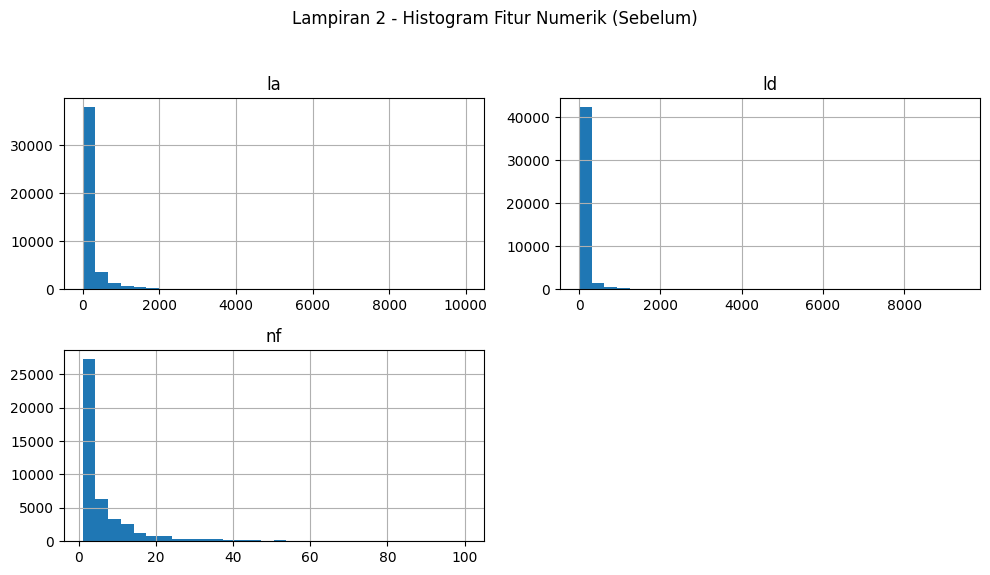

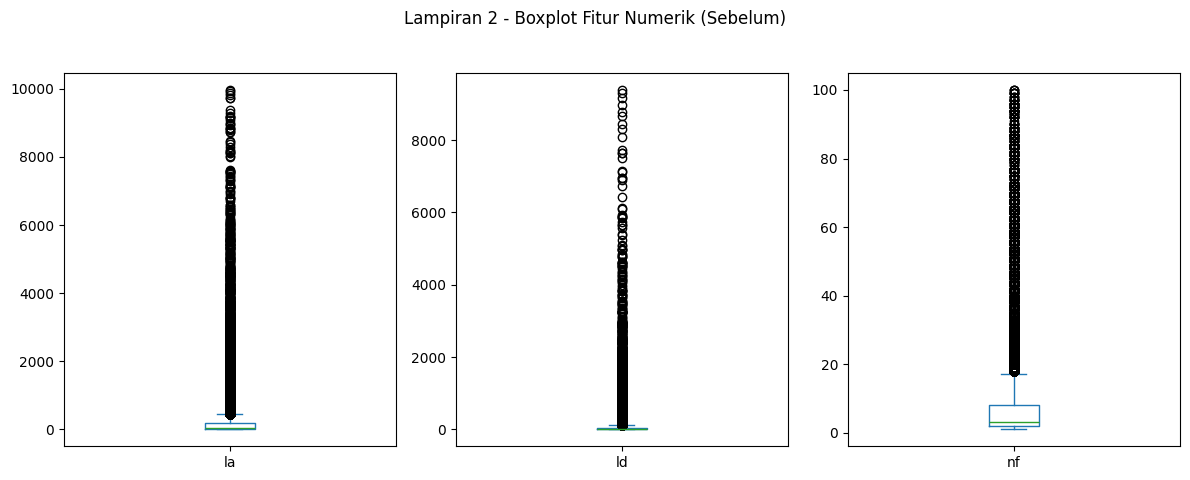

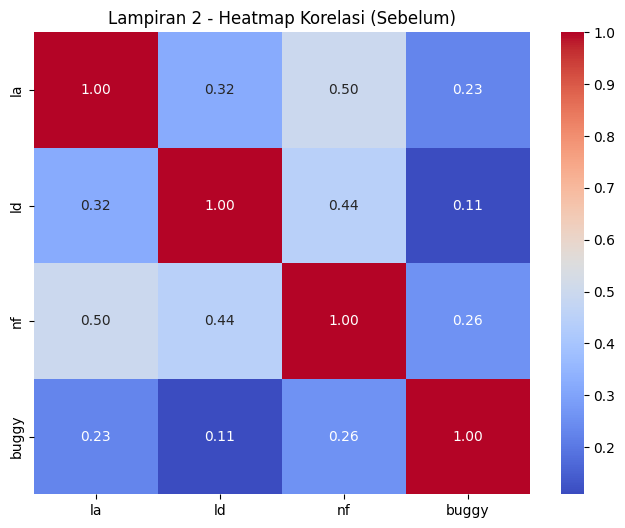


--> Menampilkan visualisasi SESUDAH preprocessing...


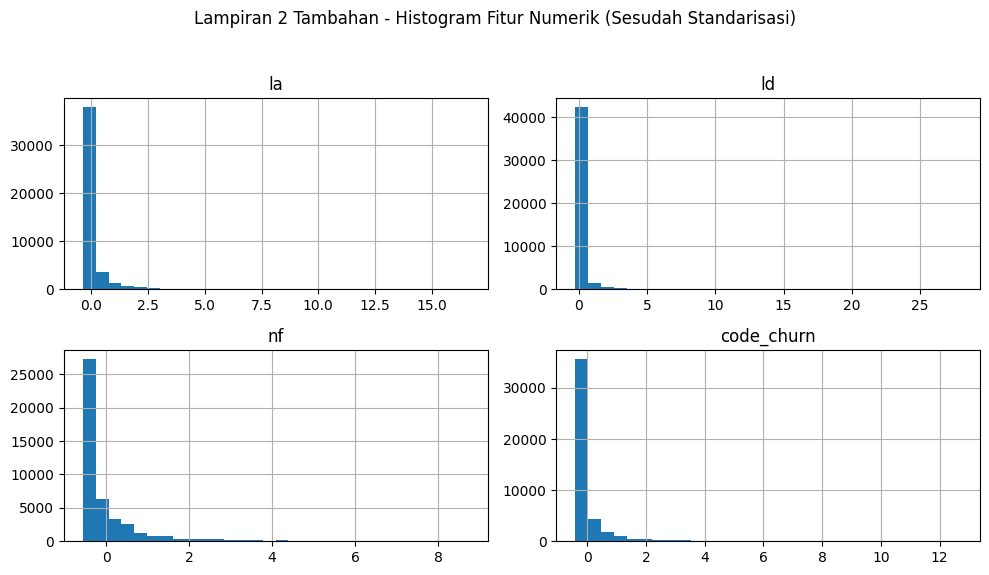

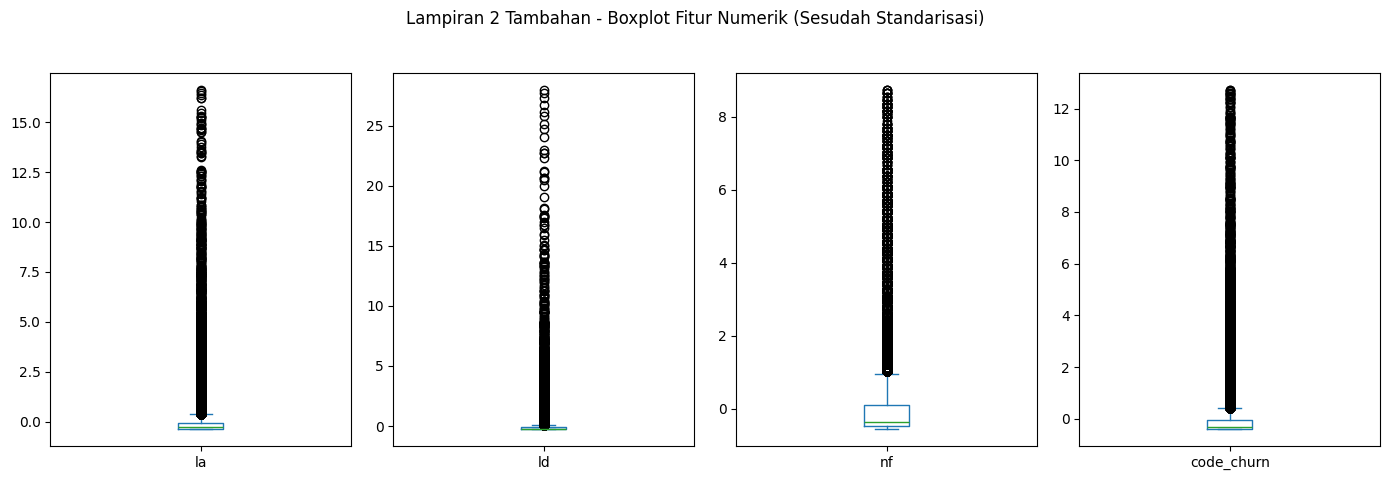

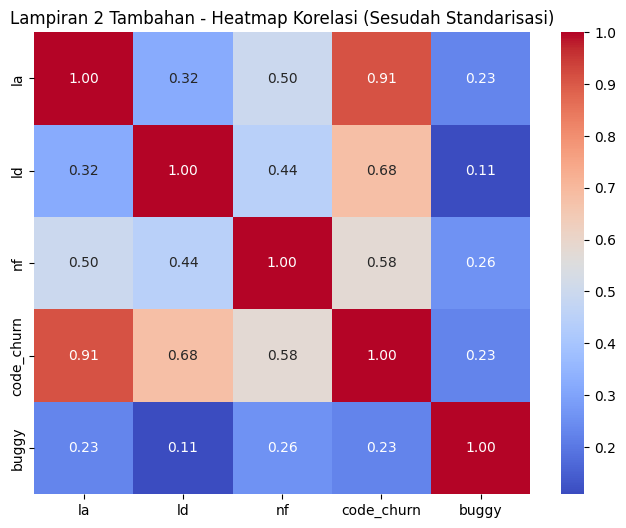

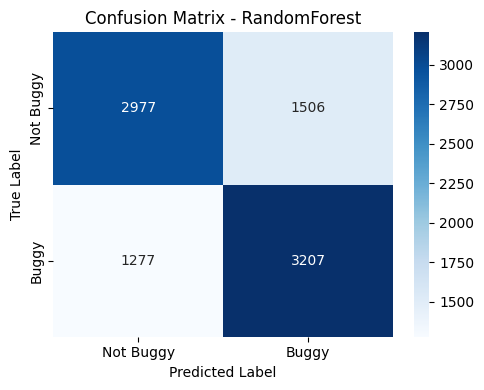

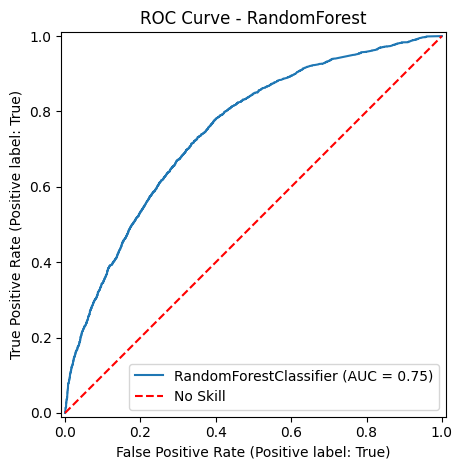

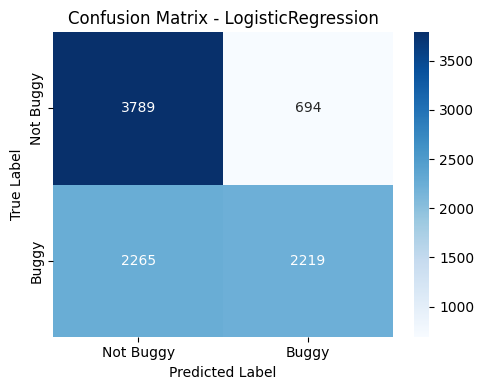

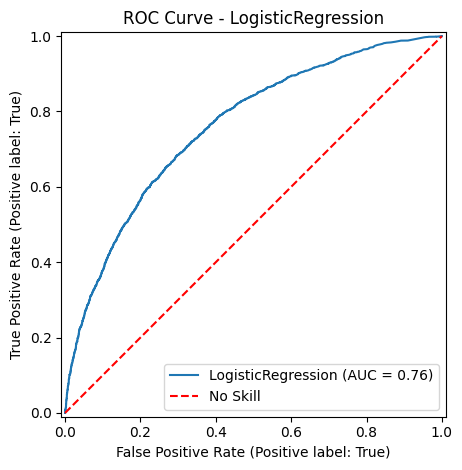


                    PROSES SELESAI


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
import os

# ==============================================================================
#                  LANGKAH 1: LAKUKAN SEMUA PROSES DATA
# ==============================================================================
print("Mohon tunggu, sedang memproses semua data...")

# Memuat Dataset Awal
try:
    df_raw = pd.read_csv("apachejit_train.csv")
except FileNotFoundError:
    print("Error: File 'apachejit_train.csv' tidak ditemukan.")
    exit()

# --- Mengambil data SEBELUM preprocessing ---
stats_before = df_raw.describe(include='all').T
stats_before['jumlah_nan'] = df_raw.isnull().sum()
initial_rows, initial_cols = df_raw.shape
initial_nans = df_raw.isnull().sum().sum()

# --- Proses Preprocessing ---
df_processed = df_raw.dropna(subset=['la', 'ld', 'nf', 'buggy']).copy()
df_processed['author_date'] = pd.to_datetime(df_processed['author_date'], errors='coerce')
df_processed.dropna(subset=['author_date'], inplace=True)
df_processed['code_churn'] = df_processed['la'] + df_processed['ld']

features = ['la', 'ld', 'nf', 'code_churn']
target = 'buggy'
X = df_processed[features]
y = df_processed[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# --- Mengambil data SESUDAH preprocessing ---
stats_after = df_processed[features + [target]].describe().T
stats_after['jumlah_nan'] = df_processed[features + [target]].isnull().sum()
final_rows, final_cols = df_processed.shape
final_nans = df_processed.isnull().sum().sum()

# --- Proses Training dan Evaluasi Model ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
# Logistic Regression
lr = LogisticRegression(C=0.1, solver='liblinear', class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Proses data selesai. Menampilkan hasil teks...")
# ==============================================================================
#                  LANGKAH 2: TAMPILKAN SEMUA HASIL TEKS
# ==============================================================================

print("\n" + "="*70)
print("     HASIL ANALISIS TEKS: SEBELUM & SESUDAH PREPROCESSING")
print("="*70)

# --- Lampiran 1: Statistik Deskriptif (SEBELUM vs SESUDAH) ---
print("\n--- Lampiran 1: Statistik Deskriptif (SEBELUM) ---")
print(stats_before.to_string())

print("\n\n--- Lampiran 1: Statistik Deskriptif (SESUDAH) ---")
print(stats_after.to_string())

# --- Lampiran 4: Tabel Perbandingan Data ---
print("\n\n--- Lampiran 4: Tabel Perbandingan Dataset ---")
comparison_data = {
    "Kriteria": ["Jumlah Baris", "Jumlah Kolom (Total)", "Jumlah Fitur (digunakan)", "Jumlah Nilai Kosong"],
    "Sebelum Preprocessing": [f"{initial_rows:,}", f"{initial_cols:,}", 3, f"{initial_nans:,}"],
    "Sesudah Preprocessing": [f"{final_rows:,}", f"{final_cols:,}", len(features), f"{final_nans:,}"]
}
df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# --- Lampiran 3: Hasil Encoding dan Normalisasi ---
print("\n\n--- Lampiran 3: Hasil Encoding dan Normalisasi ---")
print("\n1. Distribusi Variabel Target 'buggy' (Sudah Ter-encode)")
print(y.value_counts().to_string())
print("\n\n2. Perbandingan Normalisasi Fitur (5 Baris Pertama)")
print("\nSEBELUM Normalisasi:")
print(X.head().to_string())
print("\n\nSESUDAH Normalisasi (StandardScaler):")
print(X_scaled_df.head().to_string())

# --- Lampiran 6: Cuplikan Dataset Final ---
print("\n\n--- Lampiran 6: Cuplikan 10 Baris Pertama Dataset Final ---")
print(df_processed[features + [target]].head(10).to_string())

# --- Lampiran 7: Laporan Evaluasi Model ---
print("\n\n--- Lampiran 7: Laporan Evaluasi Model ---")
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, target_names=['Not Buggy (0)', 'Buggy (1)']))
print(f"ROC AUC Score: {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]):.4f}")

print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, target_names=['Not Buggy (0)', 'Buggy (1)']))
print(f"ROC AUC Score: {roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]):.4f}")

# ==============================================================================
#                  LANGKAH 3: TAMPILKAN SEMUA VISUALISASI
# ==============================================================================

print("\n" + "="*70)
print("                   MENAMPILKAN SEMUA VISUALISASI")
print("        (Tutup setiap jendela grafik untuk melanjutkan ke grafik berikutnya)")
print("="*70)

# --- Lampiran 2: Visualisasi (SEBELUM) ---
df_raw[['la', 'ld', 'nf']].hist(bins=30, figsize=(10, 6))
plt.suptitle("Lampiran 2 - Histogram Fitur Numerik (Sebelum)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

df_raw[['la', 'ld', 'nf']].plot(kind='box', subplots=True, layout=(1,3), figsize=(12,5), sharey=False)
plt.suptitle("Lampiran 2 - Boxplot Fitur Numerik (Sebelum)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(df_raw[['la', 'ld', 'nf', 'buggy']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Lampiran 2 - Heatmap Korelasi (Sebelum)")
plt.show()

# ==============================================================================
#           TAMBAHAN: VISUALISASI DATA SESUDAH PREPROCESSING
# ==============================================================================
print("\n--> Menampilkan visualisasi SESUDAH preprocessing...")

# --- Histogram SESUDAH ---
X_scaled_df.hist(bins=30, figsize=(10, 6))
plt.suptitle("Lampiran 2 Tambahan - Histogram Fitur Numerik (Sesudah Standarisasi)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Boxplot SESUDAH ---
X_scaled_df.plot(kind='box', subplots=True, layout=(1,4), figsize=(14,5), sharey=False)
plt.suptitle("Lampiran 2 Tambahan - Boxplot Fitur Numerik (Sesudah Standarisasi)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Heatmap Korelasi SESUDAH ---
# Kita tambahkan kembali target 'buggy' untuk melihat korelasi dengannya
data_after_corr = X_scaled_df.copy()
data_after_corr['buggy'] = y.values # Pastikan indexnya sesuai

plt.figure(figsize=(8, 6))
sns.heatmap(data_after_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Lampiran 2 Tambahan - Heatmap Korelasi (Sesudah Standarisasi)")
plt.show()
# --- Lampiran 7: Visualisasi Evaluasi ---
# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Buggy', 'Buggy'], yticklabels=['Not Buggy', 'Buggy'])
plt.title('Confusion Matrix - RandomForest')
plt.xlabel('Predicted Label'); plt.ylabel('True Label')
plt.tight_layout(); plt.show()

# ROC Curve - Random Forest
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title('ROC Curve - RandomForest'); plt.plot([0, 1], [0, 1], 'r--', label='No Skill')
plt.legend(); plt.tight_layout(); plt.show()

# Confusion Matrix - Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Buggy', 'Buggy'], yticklabels=['Not Buggy', 'Buggy'])
plt.title('Confusion Matrix - LogisticRegression')
plt.xlabel('Predicted Label'); plt.ylabel('True Label')
plt.tight_layout(); plt.show()

# ROC Curve - Logistic Regression
RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.title('ROC Curve - LogisticRegression'); plt.plot([0, 1], [0, 1], 'r--', label='No Skill')
plt.legend(); plt.tight_layout(); plt.show()

print("\n" + "="*70)
print("                    PROSES SELESAI")
print("="*70)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
# 1. Pembersihan Data
#    - Menghapus baris dengan nilai kosong pada kolom-kolom penting.
#    - Mengonversi 'author_date' ke format datetime dan menghapus jika ada error.
df_processed = df_raw.dropna(subset=['la', 'ld', 'nf', 'buggy']).copy()
df_processed['author_date'] = pd.to_datetime(df_processed['author_date'], errors='coerce')
df_processed.dropna(subset=['author_date'], inplace=True)
# 2. Pembuatan Fitur Baru
#    - Menambahkan fitur 'code_churn' dari penjumlahan 'la' dan 'ld'.
df_processed['code_churn'] = df_processed['la'] + df_processed['ld']
# 3. Reduksi & Seleksi Data
#    - Memilih hanya fitur-fitur yang akan digunakan untuk pemodelan.
features = ['la', 'ld', 'nf', 'code_churn']
target = 'buggy'
X = df_processed[features]
y = df_processed[target]
# 4. Transformasi Data (Normalisasi/Standarisasi)
#    - Menggunakan StandardScaler untuk mengubah skala fitur numerik.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

1. Membersihkan data...
2. Membuat fitur baru 'code_churn'...
3. Memilih fitur untuk model...
4. Melakukan normalisasi data...
Proses preprocessing selesai.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106674 entries, 0 to 106673
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   commit_id    106674 non-null  object        
 1   project      106674 non-null  object        
 2   buggy        106674 non-null  bool          
 3   fix          106674 non-null  bool          
 4   year         106674 non-null  int64         
 5   author_date  106674 non-null  datetime64[ns]
 6   la           106674 non-null  int64         
 7   ld           106674 non-null  int64         
 8   nf           106674 non-null  int64         
 9   nd           106674 non-null  int64         
 10  ns           106674 non-null  int64         
 11  ent          106674 non-null  float64       
 12  ndev         106674 non-null  float64       
 13  age          106674 non-null  float64       
 14  nuc          106674 non-null  float64       
 15  aexp         106674 non-null  int6

Mohon tunggu, sedang memuat dan memproses data...
Membuat dan memilih fitur-fitur baru yang lebih kuat...
Proses data selesai. Dataset final siap digunakan dengan 11 fitur.
Melakukan pelatihan 3 model: Random Forest, Logistic Regression, dan KNN...
Pelatihan model selesai.

             HASIL ANALISIS TEKSTUAL LENGKAP

--- Laporan Lengkap Evaluasi Model ---

=== Random Forest ===
               precision    recall  f1-score   support

Not Buggy (0)       0.76      0.77      0.77      4483
    Buggy (1)       0.77      0.76      0.76      4484

     accuracy                           0.76      8967
    macro avg       0.76      0.76      0.76      8967
 weighted avg       0.76      0.76      0.76      8967

ROC AUC Score: 0.8460

=== Logistic Regression ===
               precision    recall  f1-score   support

Not Buggy (0)       0.70      0.75      0.73      4483
    Buggy (1)       0.73      0.68      0.71      4484

     accuracy                           0.72      8967
    macro a

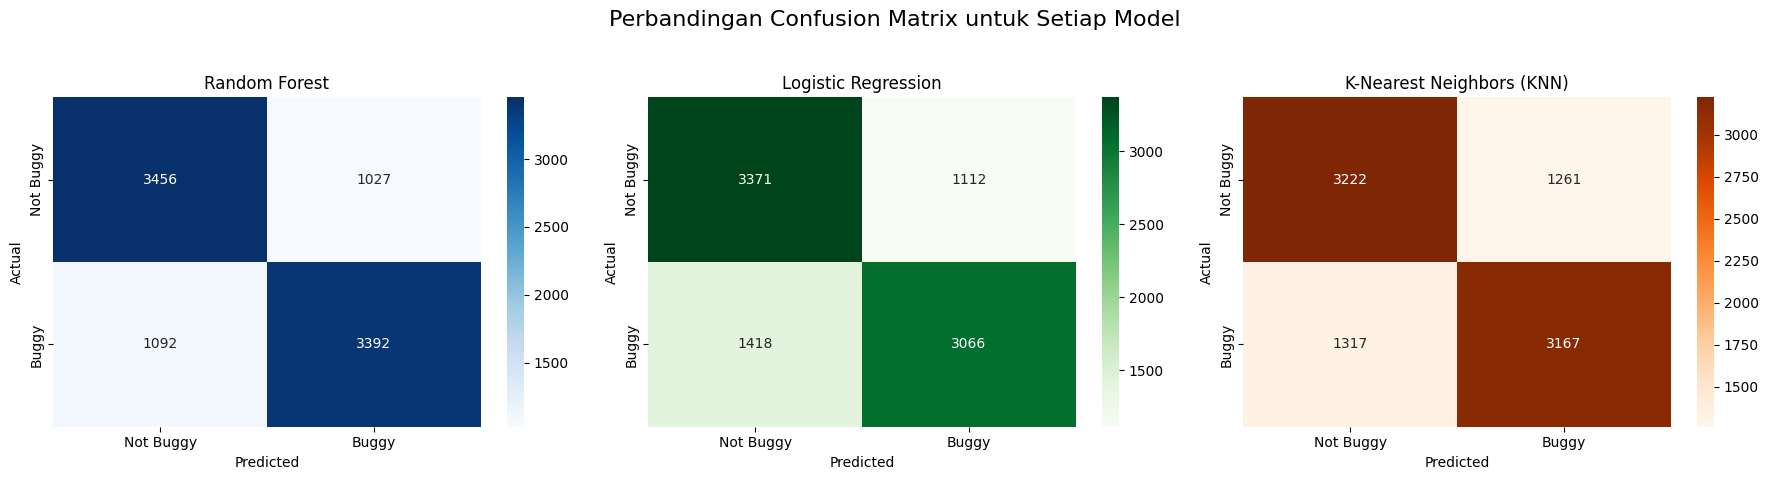

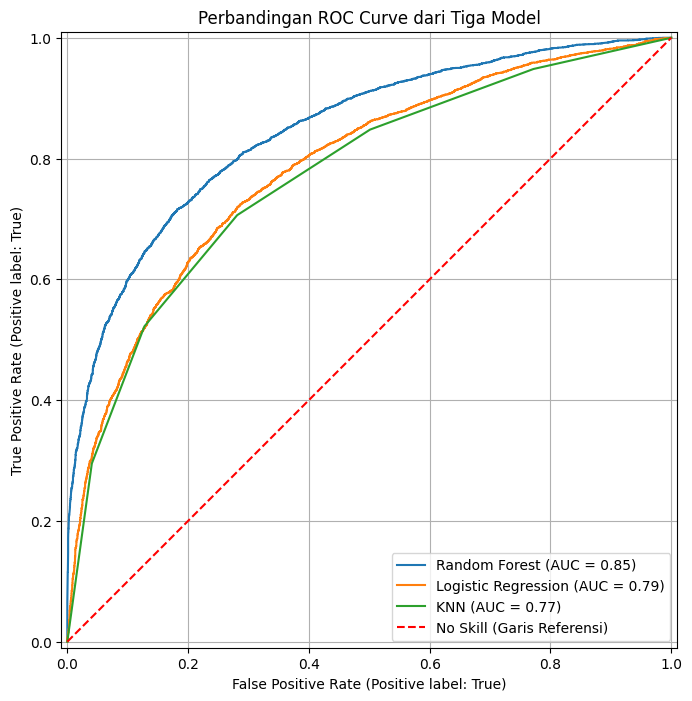


                         PROSES SELESAI


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay

# ==============================================================================
#                  LANGKAH 1: MUAT DAN PROSES DATA
# ==============================================================================
print("Mohon tunggu, sedang memuat dan memproses data...")

# Memuat Dataset Awal
try:
    # Ganti "apachejit_train.csv" jika nama file Anda berbeda
    df_raw = pd.read_csv("apachejit_train.csv")
except FileNotFoundError:
    print("Error: File 'apachejit_train.csv' tidak ditemukan. Pastikan file berada di direktori yang sama.")
    exit()

# --- Proses Preprocessing Awal ---
# Menghapus baris dengan nilai kosong pada kolom kunci awal
# Kolom 'buggy' juga disertakan untuk memastikan target tidak kosong
df_processed = df_raw.dropna(subset=['la', 'ld', 'nf', 'ent', 'buggy']).copy()

# Mengonversi dan membersihkan kolom tanggal
df_processed['author_date'] = pd.to_datetime(df_processed['author_date'], errors='coerce')
df_processed.dropna(subset=['author_date'], inplace=True)

# --- Feature Engineering & Selection (BAGIAN YANG DIPERBARUI) ---
print("Membuat dan memilih fitur-fitur baru yang lebih kuat...")

# 1. Membuat fitur 'code_churn'
df_processed['code_churn'] = df_processed['la'] + df_processed['ld']

# 2. Mengonversi fitur boolean 'fix' menjadi integer (1 untuk True, 0 untuk False)
df_processed['fix_int'] = df_processed['fix'].astype(int)

# 3. Hapus baris yang mungkin memiliki NaN di kolom fitur baru yang akan kita gunakan
# Ini penting karena kolom seperti 'aexp' atau 'nd' mungkin memiliki data kosong
new_feature_candidates = ['aexp', 'arexp', 'asexp', 'nd', 'ns']
df_processed.dropna(subset=new_feature_candidates, inplace=True)

# 4. Pastikan tipe data target adalah boolean (True/False)
df_processed['buggy'] = df_processed['buggy'].astype(bool)


# --- Pemisahan Fitur dan Target (dengan daftar fitur BARU yang lebih lengkap) ---
features = [
    # Fitur Awal
    'la',
    'ld',
    'nf',
    'ent',
    'code_churn',

    # === FITUR BARU YANG DITAMBAHKAN UNTUK AKURASI LEBIH BAIK ===
    'nd',           # Jumlah direktori yang diubah
    'ns',           # Jumlah subsistem yang diubah
    'aexp',         # Pengalaman Author (keseluruhan)
    'arexp',        # Pengalaman Author (terkini)
    'asexp',        # Pengalaman Author (di subsistem spesifik)
    'fix_int'       # Apakah commit ini adalah sebuah bug fix? (1 atau 0)
]
target = 'buggy'

X = df_processed[features]
y = df_processed[target]

# --- Normalisasi Fitur (Scaling) ---
# Proses ini tetap sama, hanya saja sekarang mencakup lebih banyak fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Proses data selesai. Dataset final siap digunakan dengan {len(features)} fitur.")

# ==============================================================================
#                      LANGKAH 2: PELATIHAN MODEL
# ==============================================================================
print("Melakukan pelatihan 3 model: Random Forest, Logistic Regression, dan KNN...")

# --- Pembagian Data Training dan Testing ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# --- Model 1: Random Forest ---
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# --- Model 2: Logistic Regression ---
lr = LogisticRegression(C=0.1, solver='liblinear', class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

# --- Model 3: K-Nearest Neighbors (KNN) ---
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:, 1]

print("Pelatihan model selesai.")

# ==============================================================================
#                  LANGKAH 3: EVALUASI & TAMPILAN HASIL
# ==============================================================================

# ------------------------------------------------------------------------------
#                           A. LAPORAN TEKSTUAL
# ------------------------------------------------------------------------------
print("\n" + "="*70)
print("             HASIL ANALISIS TEKSTUAL LENGKAP")
print("="*70)

print("\n--- Laporan Lengkap Evaluasi Model ---")
# Random Forest
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, target_names=['Not Buggy (0)', 'Buggy (1)']))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")
# Logistic Regression
print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, target_names=['Not Buggy (0)', 'Buggy (1)']))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_lr):.4f}")
# K-Nearest Neighbors (KNN)
print("\n=== K-Nearest Neighbors (KNN) ===")
print(classification_report(y_test, y_pred_knn, target_names=['Not Buggy (0)', 'Buggy (1)']))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_knn):.4f}")

# ------------------------------------------------------------------------------
#                        B. VISUALISASI EVALUASI MODEL
# ------------------------------------------------------------------------------
print("\n" + "="*70)
print("         MENAMPILKAN SEMUA VISUALISASI EVALUASI")
print("   (Tutup setiap jendela grafik untuk melanjutkan ke berikutnya)")
print("="*70)

# --- Figure untuk semua Confusion Matrix ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Perbandingan Confusion Matrix untuk Setiap Model', fontsize=16)

# Plot Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Not Buggy', 'Buggy']); axes[0].set_yticklabels(['Not Buggy', 'Buggy'])

# Plot Confusion Matrix - Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Logistic Regression')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Not Buggy', 'Buggy']); axes[1].set_yticklabels(['Not Buggy', 'Buggy'])

# Plot Confusion Matrix - K-Nearest Neighbors
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
axes[2].set_title('K-Nearest Neighbors (KNN)')
axes[2].set_xlabel('Predicted'); axes[2].set_ylabel('Actual')
axes[2].set_xticklabels(['Not Buggy', 'Buggy']); axes[2].set_yticklabels(['Not Buggy', 'Buggy'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- Figure untuk semua ROC Curve dalam satu plot ---
fig, ax = plt.subplots(figsize=(10, 8))
RocCurveDisplay.from_estimator(rf, X_test, y_test, name='Random Forest', ax=ax)
RocCurveDisplay.from_estimator(lr, X_test, y_test, name='Logistic Regression', ax=ax)
RocCurveDisplay.from_estimator(knn, X_test, y_test, name='KNN', ax=ax)
ax.plot([0, 1], [0, 1], 'r--', label='No Skill (Garis Referensi)')
plt.title('Perbandingan ROC Curve dari Tiga Model')
plt.legend()
plt.grid(True)
plt.show()

print("\n" + "="*70)
print("                         PROSES SELESAI")
print("="*70)

Mohon tunggu, sedang memuat dan memproses data...
Proses data selesai. Menggunakan 11 fitur.
Melakukan pelatihan 4 model, termasuk LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 17937, number of negative: 17930
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1947
[LightGBM] [Info] Number of data points in the train set: 35867, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Pelatihan model selesai.

             HASIL ANALISIS TEKSTUAL LENGKAP

--- Laporan Lengkap Evaluasi Model ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== Random Forest ===
               precision    recall  f1-score   support

Not Buggy (0)       0.76      0.77      0.77      4483
    Buggy (1)       0.77      0.76      0.76      4484

     accuracy                           0.76      8967
    macro avg       0.76      0.76      0.76      8967
 weighted avg       0.76      0.76      0.76      8967

ROC AUC Score: 0.8460

=== Logistic Regression ===
               precision    recall  f1-score   support

Not Buggy (0)       0.70      0.75      0.73      4483
    Buggy (1)       0.73      0.68      0.71      4484

     accuracy                           0.72      8967
    macro avg       0.72      0.72      0.72      8967
 weighted avg       0.72      0.72      0.72      8967

ROC AUC Score: 0.7854

=== K-Nearest Neighbors ===
               precision    recall  f1-score   support

Not Buggy (0)       0.71      0.72      0.71      4483
    Buggy (1)       0.72      0.71      0.71      4484

     accuracy                           0.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


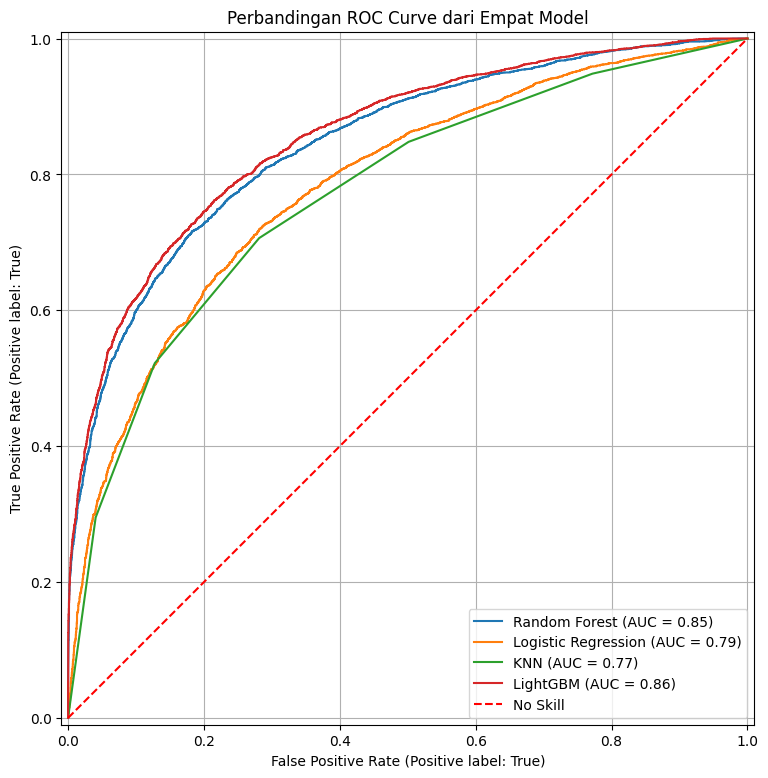


                         PROSES SELESAI


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb  # <-- IMPORT MODEL BARU
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay

# ==============================================================================
#                  LANGKAH 1: MUAT DAN PROSES DATA (TETAP SAMA)
# ==============================================================================
print("Mohon tunggu, sedang memuat dan memproses data...")
try:
    df_raw = pd.read_csv("apachejit_train.csv")
except FileNotFoundError:
    print("Error: File 'apachejit_train.csv' tidak ditemukan.")
    exit()

# Preprocessing dan Feature Engineering
df_processed = df_raw.dropna(subset=['la', 'ld', 'nf', 'ent', 'buggy']).copy()
df_processed['author_date'] = pd.to_datetime(df_processed['author_date'], errors='coerce')
df_processed.dropna(subset=['author_date'], inplace=True)
df_processed['code_churn'] = df_processed['la'] + df_processed['ld']
df_processed['fix_int'] = df_processed['fix'].astype(int)
new_feature_candidates = ['aexp', 'arexp', 'asexp', 'nd', 'ns']
df_processed.dropna(subset=new_feature_candidates, inplace=True)
df_processed['buggy'] = df_processed['buggy'].astype(bool)

# Daftar Fitur Lengkap
features = ['la', 'ld', 'nf', 'ent', 'code_churn', 'nd', 'ns', 'aexp', 'arexp', 'asexp', 'fix_int']
target = 'buggy'

X = df_processed[features]
y = df_processed[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Proses data selesai. Menggunakan {len(features)} fitur.")

# ==============================================================================
#                      LANGKAH 2: PELATIHAN MODEL
# ==============================================================================
print("Melakukan pelatihan 4 model, termasuk LightGBM...")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Model 1: Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Model 2: Logistic Regression
lr = LogisticRegression(C=0.1, solver='liblinear', class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

# Model 3: K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)
y_proba_knn = knn.predict_proba(X_test)[:, 1]

# --- Model 4: LightGBM (LGBM) - REKOMENDASI BARU ---
lgbm = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
lgbm.fit(X_train, y_train)
y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]

print("Pelatihan model selesai.")

# ==============================================================================
#                  LANGKAH 3: EVALUASI & TAMPILAN HASIL
# ==============================================================================
print("\n" + "="*70)
print("             HASIL ANALISIS TEKSTUAL LENGKAP")
print("="*70)
print("\n--- Laporan Lengkap Evaluasi Model ---")

# Menambahkan prediksi untuk laporan klasifikasi
models = {
    "Random Forest": (rf.predict(X_test), y_proba_rf),
    "Logistic Regression": (lr.predict(X_test), y_proba_lr),
    "K-Nearest Neighbors": (knn.predict(X_test), y_proba_knn),
    "LightGBM": (lgbm.predict(X_test), y_proba_lgbm)
}

for name, (y_pred, y_proba) in models.items():
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=['Not Buggy (0)', 'Buggy (1)']))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# --- Visualisasi ROC Curve ---
print("\n--> Menampilkan visualisasi perbandingan ROC Curve...")
fig, ax = plt.subplots(figsize=(12, 9))
RocCurveDisplay.from_estimator(rf, X_test, y_test, name='Random Forest', ax=ax)
RocCurveDisplay.from_estimator(lr, X_test, y_test, name='Logistic Regression', ax=ax)
RocCurveDisplay.from_estimator(knn, X_test, y_test, name='KNN', ax=ax)
RocCurveDisplay.from_estimator(lgbm, X_test, y_test, name='LightGBM', ax=ax) # Tambahkan LGBM ke plot
ax.plot([0, 1], [0, 1], 'r--', label='No Skill')
plt.title('Perbandingan ROC Curve dari Empat Model')
plt.legend()
plt.grid(True)
plt.show()

print("\n" + "="*70)
print("                         PROSES SELESAI")
print("="*70)

Mohon tunggu, sedang memuat dan memproses data...
Proses data selesai. Menggunakan 11 fitur.
Melakukan pelatihan 5 model, termasuk XGBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 17937, number of negative: 17930
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1947
[LightGBM] [Info] Number of data points in the train set: 35867, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/tmp/ipython-input-11-1714865475.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:39:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pelatihan model selesai.

             HASIL ANALISIS TEKSTUAL LENGKAP

--- Laporan Lengkap Evaluasi Model ---

=== Random Forest ===
               precision    recall  f1-score   support

Not Buggy (0)       0.76      0.77      0.76      4483
    Buggy (1)       0.77      0.75      0.76      4484

     accuracy                           0.76      8967
    macro avg       0.76      0.76      0.76      8967
 weighted avg       0.76      0.76      0.76      8967

ROC AUC Score: 0.8421

=== Logistic Regression ===
               precision    recall  f1-score   support

Not Buggy (0)       0.70      0.75      0.73      4483
    Buggy (1)       0.73      0.68      0.71      4484

     accuracy                           0.72      8967
    macro avg       0.72      0.72      0.72      8967
 weighted avg       0.72      0.72      0.72      8967

ROC AUC Score: 0.7854

=== K-Nearest Neighbors ===
               precision    recall  f1-score   support

Not Buggy (0)       0.71      0.72      0.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== XGBoost ===
               precision    recall  f1-score   support

Not Buggy (0)       0.76      0.78      0.77      4483
    Buggy (1)       0.78      0.75      0.76      4484

     accuracy                           0.77      8967
    macro avg       0.77      0.77      0.77      8967
 weighted avg       0.77      0.77      0.77      8967

ROC AUC Score: 0.8501

--> Menampilkan visualisasi perbandingan ROC Curve...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


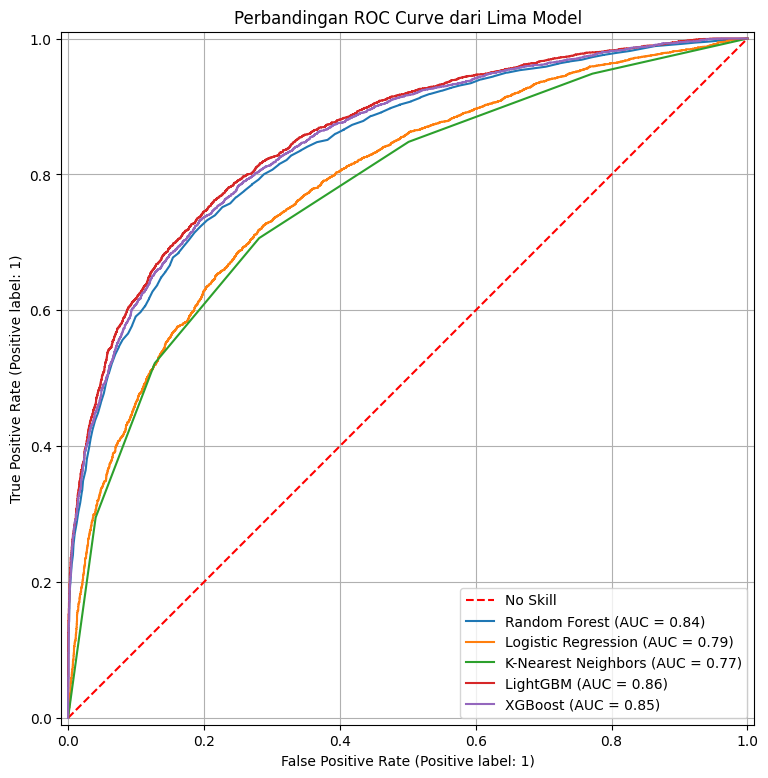


                         PROSES SELESAI


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import xgboost as xgb # <-- IMPORT MODEL BARU
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

# ==============================================================================
#                  LANGKAH 1: MUAT DAN PROSES DATA
# ==============================================================================
print("Mohon tunggu, sedang memuat dan memproses data...")
try:
    df_raw = pd.read_csv("apachejit_train.csv")
except FileNotFoundError:
    print("Error: File 'apachejit_train.csv' tidak ditemukan.")
    exit()

# Preprocessing dan Feature Engineering
df_processed = df_raw.dropna(subset=['la', 'ld', 'nf', 'ent', 'buggy']).copy()
df_processed['author_date'] = pd.to_datetime(df_processed['author_date'], errors='coerce')
df_processed.dropna(subset=['author_date'], inplace=True)
df_processed['code_churn'] = df_processed['la'] + df_processed['ld']
df_processed['fix_int'] = df_processed['fix'].astype(int)
new_feature_candidates = ['aexp', 'arexp', 'asexp', 'nd', 'ns']
df_processed.dropna(subset=new_feature_candidates, inplace=True)
df_processed['buggy'] = df_processed['buggy'].astype(bool)

# Daftar Fitur Lengkap
features = ['la', 'ld', 'nf', 'ent', 'code_churn', 'nd', 'ns', 'aexp', 'arexp', 'asexp', 'fix_int']
target = 'buggy'

X = df_processed[features]
y = df_processed[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Proses data selesai. Menggunakan {len(features)} fitur.")

# ==============================================================================
#                      LANGKAH 2: PELATIHAN MODEL
# ==============================================================================
print("Melakukan pelatihan 5 model, termasuk XGBoost...")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Model 1: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)

# Model 2: Logistic Regression
lr = LogisticRegression(random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)

# Model 3: K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)

# Model 4: LightGBM (LGBM)
lgbm = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
lgbm.fit(X_train, y_train)

# --- Model 5: XGBoost (XGB) - REKOMENDASI BARU ---
# Untuk data tidak seimbang, kita atur `scale_pos_weight`
# Hitung rasio kelas negatif terhadap positif
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=ratio)
xgb_clf.fit(X_train, y_train)

print("Pelatihan model selesai.")

# ==============================================================================
#                  LANGKAH 3: EVALUASI & TAMPILAN HASIL
# ==============================================================================
print("\n" + "="*70)
print("             HASIL ANALISIS TEKSTUAL LENGKAP")
print("="*70)
print("\n--- Laporan Lengkap Evaluasi Model ---")

# Kumpulkan semua model dan hasil prediksinya
models = {
    "Random Forest": rf,
    "Logistic Regression": lr,
    "K-Nearest Neighbors": knn,
    "LightGBM": lgbm,
    "XGBoost": xgb_clf
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=['Not Buggy (0)', 'Buggy (1)']))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# --- Visualisasi ROC Curve ---
print("\n--> Menampilkan visualisasi perbandingan ROC Curve...")
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot([0, 1], [0, 1], 'r--', label='No Skill')

for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name, ax=ax)

plt.title('Perbandingan ROC Curve dari Lima Model')
plt.legend()
plt.grid(True)
plt.show()

print("\n" + "="*70)
print("                         PROSES SELESAI")
print("="*70)

Mohon tunggu, sedang memuat dan memproses data...
Proses data selesai. Menggunakan 11 fitur.

--> Menampilkan visualisasi distribusi data (tutup plot untuk melanjutkan)...


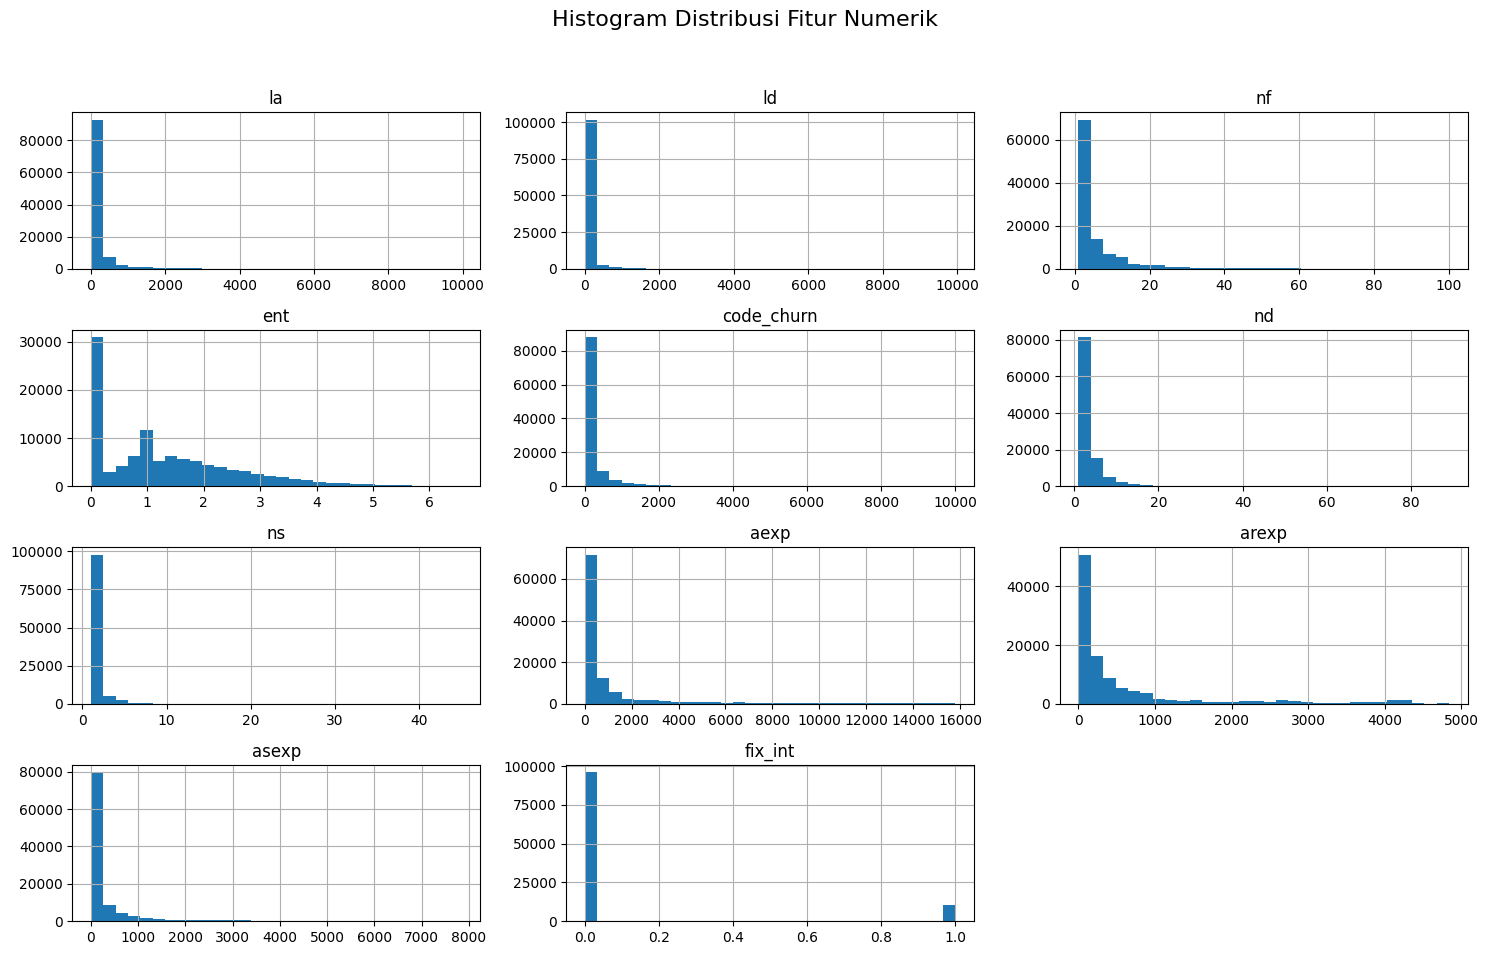

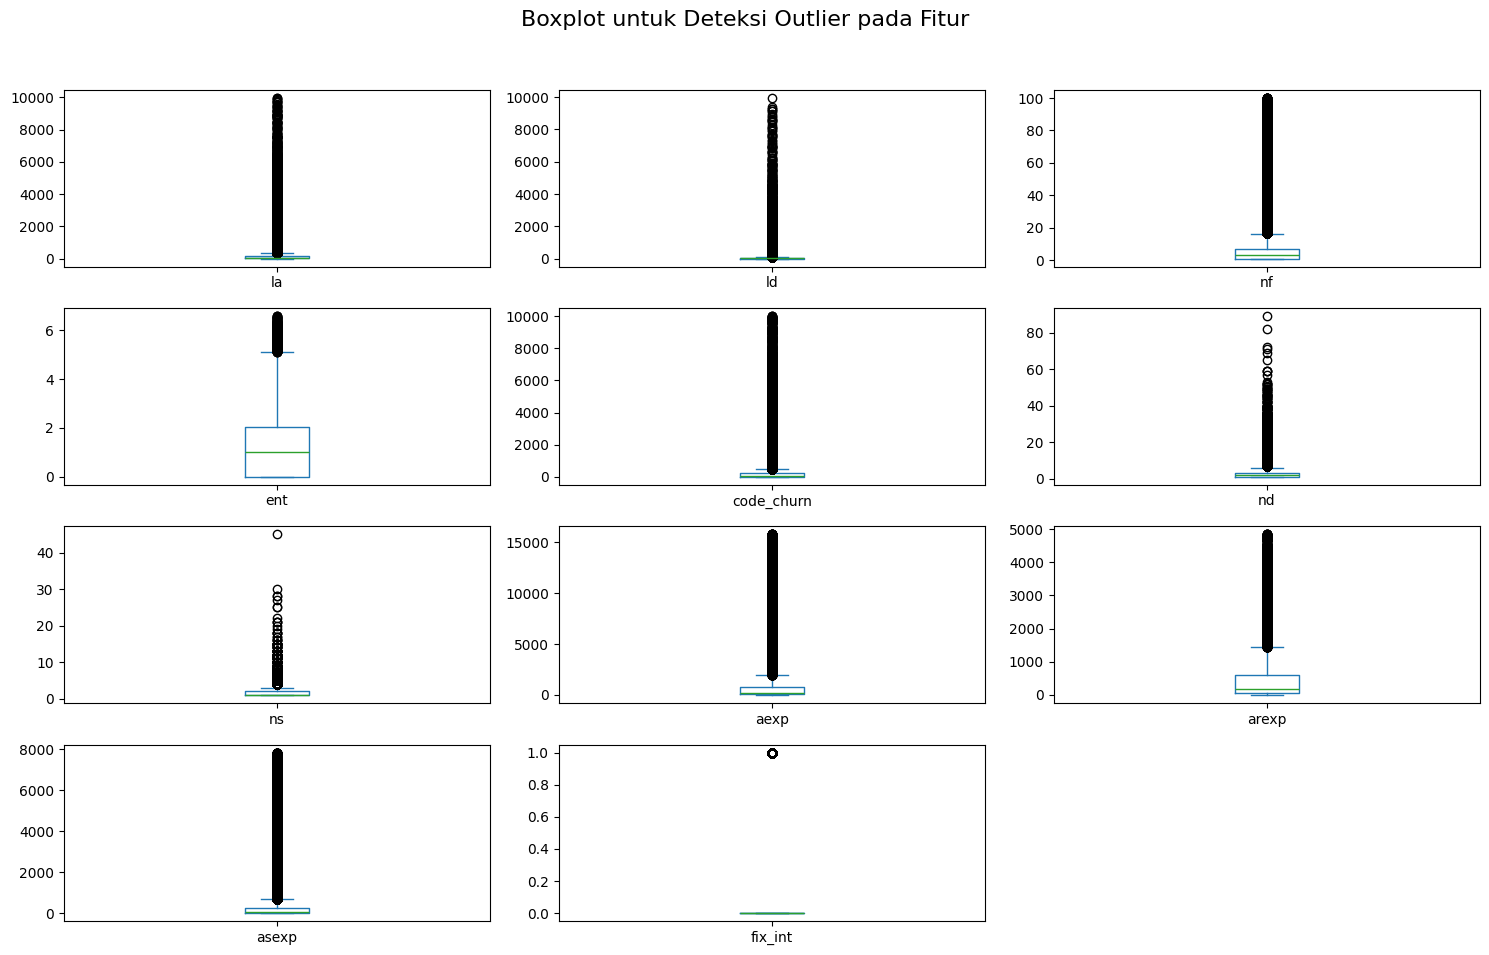

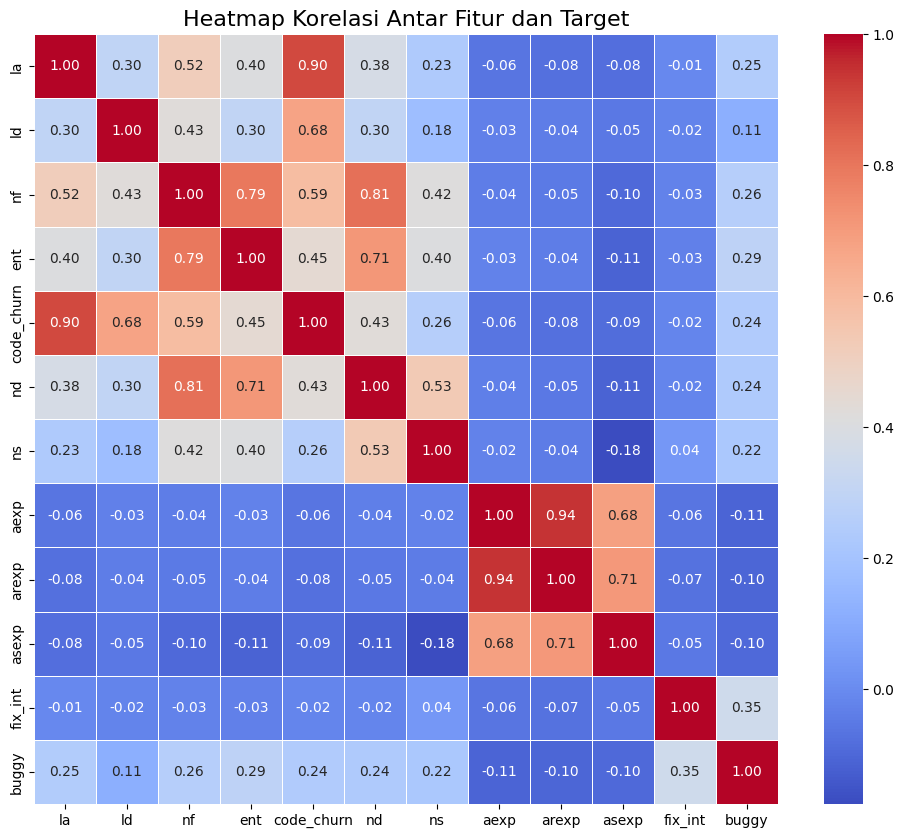


Melakukan pelatihan 5 model...
Melatih Random Forest...


/tmp/ipython-input-13-1472618111.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))


Melatih Logistic Regression...
Melatih K-Nearest Neighbors...
Melatih LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 22591, number of negative: 62748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 85339, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Melatih XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:24:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pelatihan model selesai.

             HASIL ANALISIS DAN EVALUASI LENGKAP

--- A. Laporan Pra-Pemrosesan Data ---

1. Tabel Perbandingan Dataset (Sebelum vs. Sesudah)
           Kriteria Sebelum Preprocessing Sesudah Preprocessing
       Jumlah Baris               106,674               106,674
       Jumlah Kolom                    18                    20
Jumlah Nilai Kosong                     0                     0


2. Tabel Hasil Encoding dan Normalisasi

   Encoding Fitur 'fix' (boolean -> integer):
       Sebelum  Sesudah (fix_int)
False    95984              95984
True     10690              10690


   Normalisasi Fitur Numerik (5 baris pertama):

   SEBELUM Normalisasi (StandardScaler):
    la  ld  nf       ent  code_churn  nd  ns  aexp  arexp      asexp  fix_int
0  372  23   8  2.669743         395   3   3   243  243.0   0.683585        0
1    2   2   2  1.000000           4   2   1    19   19.0  14.000000        0
2   41  26   3  1.237612          67   3   2   233  233.0  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== LightGBM ===
               precision    recall  f1-score   support

Not Buggy (0)       0.89      0.80      0.85     15687
    Buggy (1)       0.57      0.73      0.64      5648

     accuracy                           0.78     21335
    macro avg       0.73      0.77      0.74     21335
 weighted avg       0.81      0.78      0.79     21335

ROC AUC Score: 0.8528

=== XGBoost ===
               precision    recall  f1-score   support

Not Buggy (0)       0.89      0.81      0.85     15687
    Buggy (1)       0.58      0.73      0.64      5648

     accuracy                           0.79     21335
    macro avg       0.73      0.77      0.74     21335
 weighted avg       0.81      0.79      0.79     21335

ROC AUC Score: 0.8493


--- C. Visualisasi Hasil Evaluasi ---

--> Menampilkan Confusion Matrix untuk setiap model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


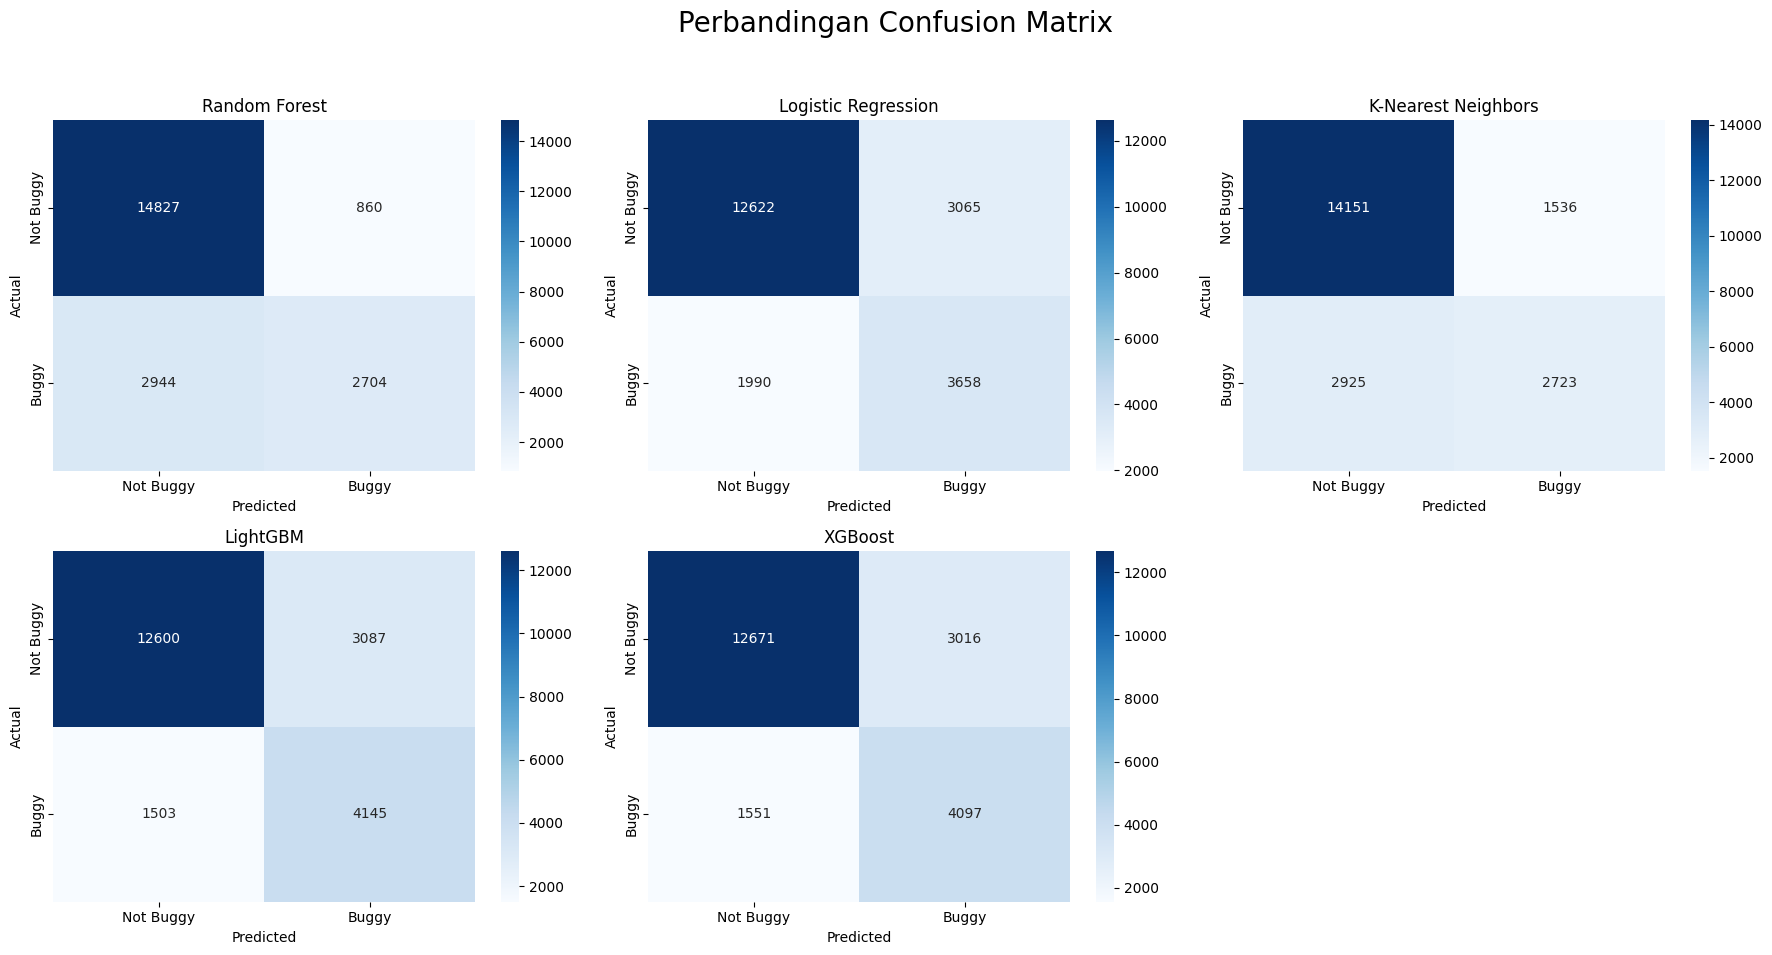


--> Menampilkan visualisasi perbandingan ROC Curve...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


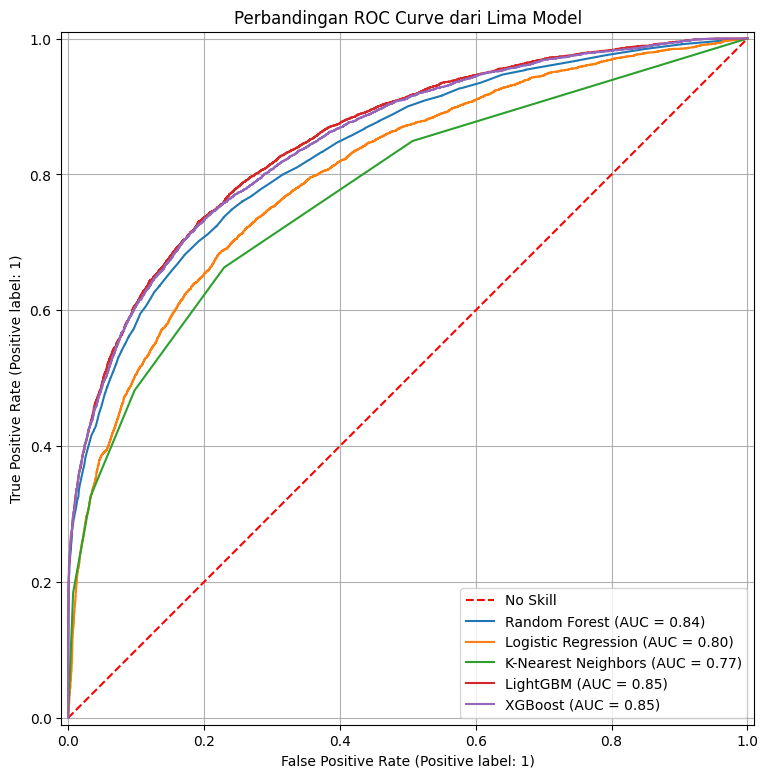


                         PROSES SELESAI


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix

# ==============================================================================
#                  LANGKAH 1: MUAT DAN PROSES DATA
# ==============================================================================
print("Mohon tunggu, sedang memuat dan memproses data...")
try:
    df_raw = pd.read_csv("apachejit_total.csv")
except FileNotFoundError:
    print("Error: File 'apachejit_train.csv' tidak ditemukan.")
    exit()

# Simpan statistik sebelum preprocessing
initial_rows, initial_cols = df_raw.shape
initial_nans = df_raw.isnull().sum().sum()

# Preprocessing dan Feature Engineering
df_processed = df_raw.dropna(subset=['la', 'ld', 'nf', 'ent', 'buggy']).copy()
df_processed['author_date'] = pd.to_datetime(df_processed['author_date'], errors='coerce')
df_processed.dropna(subset=['author_date'], inplace=True)
df_processed['code_churn'] = df_processed['la'] + df_processed['ld']
df_processed['fix_int'] = df_processed['fix'].astype(int)
new_feature_candidates = ['aexp', 'arexp', 'asexp', 'nd', 'ns']
df_processed.dropna(subset=new_feature_candidates, inplace=True)
df_processed['buggy'] = df_processed['buggy'].astype(bool)

# Daftar Fitur Lengkap
features = ['la', 'ld', 'nf', 'ent', 'code_churn', 'nd', 'ns', 'aexp', 'arexp', 'asexp', 'fix_int']
target = 'buggy'

X = df_processed[features]
y = df_processed[target]

# Simpan statistik sesudah preprocessing
final_rows, final_cols_processed = df_processed.shape
final_nans = df_processed.isnull().sum().sum()

# Normalisasi / Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features) # Buat dataframe untuk perbandingan
print(f"Proses data selesai. Menggunakan {len(features)} fitur.")


# ==============================================================================
#              LANGKAH 2 (BARU): EKSPLORASI & VISUALISASI DATA
# ==============================================================================
print("\n--> Menampilkan visualisasi distribusi data (tutup plot untuk melanjutkan)...")

# --- Visualisasi 1: Histogram untuk melihat distribusi setiap fitur ---
X.hist(bins=30, figsize=(15, 10), layout=(4, 3))
plt.suptitle("Histogram Distribusi Fitur Numerik", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Visualisasi 2: Boxplot untuk melihat outlier ---
X.plot(kind='box', subplots=True, layout=(4, 3), figsize=(15, 10), sharey=False)
plt.suptitle("Boxplot untuk Deteksi Outlier pada Fitur", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Visualisasi 3: Heatmap Korelasi ---
plt.figure(figsize=(12, 10))
# Gabungkan fitur dan target untuk melihat korelasi dengan 'buggy'
correlation_data = X.copy()
correlation_data['buggy'] = y.astype(int)
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Heatmap Korelasi Antar Fitur dan Target", fontsize=16)
plt.show()


# ==============================================================================
#                      LANGKAH 3: PELATIHAN MODEL
# ==============================================================================
print("\nMelakukan pelatihan 5 model...")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

models_dict = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))
}

for name, model in models_dict.items():
    print(f"Melatih {name}...")
    model.fit(X_train, y_train)

print("Pelatihan model selesai.")


# ==============================================================================
#              LANGKAH 4: EVALUASI & TAMPILAN HASIL (DIPERBARUI)
# ==============================================================================
print("\n" + "="*70)
print("             HASIL ANALISIS DAN EVALUASI LENGKAP")
print("="*70)

# --- Bagian A: Laporan Pra-Pemrosesan (BARU) ---
print("\n--- A. Laporan Pra-Pemrosesan Data ---")

# Tabel Perbandingan Data
print("\n1. Tabel Perbandingan Dataset (Sebelum vs. Sesudah)")
comparison_data = {
    "Kriteria": ["Jumlah Baris", "Jumlah Kolom", "Jumlah Nilai Kosong"],
    "Sebelum Preprocessing": [f"{initial_rows:,}", f"{initial_cols:,}", f"{initial_nans:,}"],
    "Sesudah Preprocessing": [f"{final_rows:,}", f"{final_cols_processed:,}", f"{final_nans:,}"]
}
df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# Tabel Hasil Encoding dan Normalisasi
print("\n\n2. Tabel Hasil Encoding dan Normalisasi")
print("\n   Encoding Fitur 'fix' (boolean -> integer):")
print(pd.concat([df_raw['fix'].value_counts(), df_processed['fix_int'].value_counts()], axis=1, keys=['Sebelum', 'Sesudah (fix_int)']).to_string())

print("\n\n   Normalisasi Fitur Numerik (5 baris pertama):")
print("\n   SEBELUM Normalisasi (StandardScaler):")
print(X.head().to_string())
print("\n   SESUDAH Normalisasi (StandardScaler):")
print(X_scaled_df.head().to_string())


# --- Bagian B: Laporan Kinerja Model (Teks) ---
print("\n\n--- B. Laporan Lengkap Kinerja Model ---")
for name, model in models_dict.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=['Not Buggy (0)', 'Buggy (1)']))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# --- Bagian C: Visualisasi Hasil (DIPERBARUI) ---
print("\n\n--- C. Visualisasi Hasil Evaluasi ---")
print("\n--> Menampilkan Confusion Matrix untuk setiap model...")

# Confusion Matrix
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten() # Ratakan array axes agar mudah di-loop
fig.suptitle('Perbandingan Confusion Matrix', fontsize=20)

for i, (name, model) in enumerate(models_dict.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted'); axes[i].set_ylabel('Actual')
    axes[i].set_xticklabels(['Not Buggy', 'Buggy']); axes[i].set_yticklabels(['Not Buggy', 'Buggy'])

# Sembunyikan subplot yang tidak terpakai
if len(models_dict) < len(axes):
    for j in range(len(models_dict), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ROC Curve
print("\n--> Menampilkan visualisasi perbandingan ROC Curve...")
fig, ax = plt.subplots(figsize=(12, 9))
ax.plot([0, 1], [0, 1], 'r--', label='No Skill')
for name, model in models_dict.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name, ax=ax)
plt.title('Perbandingan ROC Curve dari Lima Model')
plt.legend()
plt.grid(True)
plt.show()

print("\n" + "="*70)
print("                         PROSES SELESAI")
print("="*70)

In [14]:
print("\n\n--- Lampiran 6: Cuplikan 10 Baris Pertama Dataset Final ---")
print(df_processed[features + [target]].head(10).to_string())



--- Lampiran 6: Cuplikan 10 Baris Pertama Dataset Final ---
    la  ld  nf       ent  code_churn  nd  ns  aexp  arexp       asexp  fix_int  buggy
0  372  23   8  2.669743         395   3   3   243  243.0    0.683585        0  False
1    2   2   2  1.000000           4   2   1    19   19.0   14.000000        0  False
2   41  26   3  1.237612          67   3   2   233  233.0    0.000606        0  False
3    8   6   2  0.591673          14   1   1    64   64.0   55.000000        0  False
4   70   4   6  2.519672          74   3   1    27   27.0   22.000000        0  False
5  104  29   7  2.313248         133   5   1   273  273.0  215.000000        0  False
6    9   0   1  0.000000           9   1   1    49   49.0   27.000000        0  False
7   58   0   1  0.000000          58   1   1    37   37.0   16.000000        0  False
8   65   0   1  0.000000          65   1   1    38   38.0   17.000000        0  False
9   19   3   2  0.439497          22   2   1    66   66.0   42.000000        0